# Table of Content

This notebook details the code used to derive the eventual optimal model. Throughout the iterative process of deriving our optimal model, 5 models were tried and we eventually settled on the last model, Model 5. Below shows the main section of this notebook.

0. Load in data 

1. Helper functions to perform cross validation

2. Model 1: Mean Squared Error with GD using original imbalanced dataset

3. Model 2: Logistic Regression with GD using original imbalanced dataset

4. Model 3: Logistic Regression with GD using downsampled dataset

5. Model 4: Logistic Regression with GD using downsampled, feature reduced dataset

6. Model 5: Regularised Logistic Regression with GD using downsampled, feature reduced dataset

7. Summary of results

8. Generation of test submission

*Note: GD - Gradient Descent*

In [5]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Load in data

In [4]:
from data_loader import *

x_train_np = load_x_data('datasets/updated_ds/x_train.npy')
x_test_np = load_x_data('datasets/updated_ds/x_test.npy')

print(x_train_np.shape) # (328135, 26)
print(x_test_np.shape) # (109379, 26)

(328135, 26)
(109379, 26)


In [3]:
y_train = load_y_data('datasets/updated_ds/y_train.npy', True)
print(y_train.shape) # (328135,)

(328135,)


## 1. Helper functions to perform cross validation

In [ ]:
from implementations import *
from utils import *
from models import *

In [6]:
# Function to generate indices for k fold
def build_k_indices(y, k_fold):
    
    """This function generates the k_indices to perform k-fold cross validation.
    
    Args:
        y: numpy array of response variable, y
        k_fold: number of folds
        seed: the random seed
    
    Returns:
        Indices for the test data points for each fold in k-fold cross validation
    """
    
    # Determine number of data points and interval for making fold
    N = y.shape[0]
    interval = int(N/ k_fold)
    
    # Set random seed and randomised indexes
    # np.random.seed(seed)
    indices = np.random.permutation(N)
    
    # Get the indices for each fold
    # Return the indices
    k_indices = [indices[k*interval: (k+1)*interval] for k in range(k_fold)]
    return k_indices

In [7]:
def get_kfold_train_test(y, x, k_indices, k):
    
    """Returns the train and test datasets for x and y at the current fold

    Args:
        y: shape=(N,)
        x: shape=(N,D)
        k_indices: 2D array returned by build_k_indices()
        k: scalar, the k-th fold (N.B.: not to confused with k_fold which is the fold nums)
        
    Returns:
        train_x, train_y, test_x, test_y
    """
    
    # get k'th fold indices
    test_indices = k_indices[k]
    train_indices = np.squeeze(np.delete(k_indices, k, 0))
    
    # Convert 2D array into 1D to index respective rows
    train_indices = train_indices.flatten()

    # get k'th fold x and y's data
    train_x, train_y = x[train_indices], y[train_indices]
    test_x, test_y = x[test_indices], y[test_indices] 
    
    return train_x, train_y, test_x, test_y

In [8]:
def cross_validation(y, x, k_indices, k, model, lambda_ = None):
    
    """Return the loss of a chosen loss function for a fold corresponding to k_indices

    Args:
        y: numpy array of shape = (N,)
        x: numpy array of shape = (N,D)
        k_indices: 2D array returned by build_k_indices()
        k: scalar, the k-th fold (N.B.: not to confused with k_fold which is the fold nums)
        model: model to be trained
        lambda_: float, lambda_ value for regularisation
        
    Returns:
        train and test loss for a fold for the corresponding loss fnc
    """
    
    # get k'th fold indices
    test_indices = k_indices[k]
    train_indices = np.squeeze(np.delete(k_indices, k, 0))
    
    # Convert 2D array into 1D to index respective rows
    train_indices = train_indices.flatten()

    # get k'th fold x and y's data
    train_x, train_y = x[train_indices], y[train_indices]
    test_x, test_y = x[test_indices], y[test_indices]  
    
    initial_w = np.zeros((x.shape[1],), dtype = np.float64)
    if lambda_ is None:
        w, train_loss = model.train(train_y, train_x, initial_w, 100, 0.1)
    else:
        w, train_loss = model.train(train_y, train_x, lambda_, initial_w, 100, 0.1)
        
    test_loss = model.calc_loss(test_y, test_x, w)
    
    return train_loss, test_loss

## 2. Model 1: Mean Squared Error with GD using original imbalanced dataset

In [9]:
# Instantiate model
print_every = 6
epochs = 12
num_folds = 5

In [10]:
'''Test MSE function'''

# Build k indices
k_indices = build_k_indices(y_train, num_folds)

mse_train_losses = []
mse_test_losses = []
mse_accuracies = []
mse_recalls = []
mse_precisions = []
mse_f1_scores = []

_iter = 0

for epoch_num in range(epochs):
    for fold_num in range(num_folds):
        
        # Instantiate model
        model = MeanSquared_Model('mse_gd', mean_squared_error_gd, compute_mse_loss)

        # Train model
        tr_loss, te_loss = cross_validation(y_train, x_train_np,
                                            k_indices, fold_num, model)
        
        # Get train and test split
        train_x, train_y, test_x, test_y = get_kfold_train_test(y_train, x_train_np, k_indices, fold_num)
        
        # Predict and get metrics
        test_y_pred = model.predict(test_x)
        
        acc = model.calc_acc(test_y, test_y_pred)
        recall, precision, weighted_f1 = model.calc_metrics(test_y, test_y_pred)
        
        mse_train_losses.append(tr_loss)
        mse_test_losses.append(te_loss)
        mse_accuracies.append(acc)
        mse_recalls.append(recall)
        mse_precisions.append(precision)
        mse_f1_scores.append(weighted_f1)
        
        if _iter > 0 and _iter % print_every == 0:
            print(f'Iter no: {_iter}, train loss: {mse_train_losses[_iter]}, test loss: {mse_test_losses[_iter]}, accuracy: {mse_accuracies[_iter]}, recalls: {mse_recalls[_iter]}, precisions: {mse_precisions[_iter]}, f1: {mse_f1_scores[_iter]}')
        _iter += 1

Iter no: 6, train loss: 0.034557011943276914, test loss: 0.03459404573056781, accuracy: 0.9115607905282886, recalls: 0.00292146416910122, precisions: 0.8947368421052632, f1: 0.005823912298732442
Iter no: 12, train loss: 0.034582094073373676, test loss: 0.03450961463745055, accuracy: 0.911896018407058, recalls: 0.002072180970471421, precisions: 0.8, f1: 0.004133654839820875
Iter no: 18, train loss: 0.03448238360137277, test loss: 0.03489099495300713, accuracy: 0.9108446218781904, recalls: 0.003239556692242114, precisions: 0.7916666666666666, f1: 0.006452708439463406
Iter no: 24, train loss: 0.03467873214492334, test loss: 0.0340805143375782, accuracy: 0.9137702470019962, recalls: 0.003350970017636684, precisions: 0.7037037037037037, f1: 0.006670177286291029
Iter no: 30, train loss: 0.03451538377341078, test loss: 0.03475841645218772, accuracy: 0.9114388894814635, recalls: 0.003430531732418525, precisions: 0.9090909090909091, f1: 0.006835269993164731
Iter no: 36, train loss: 0.0345570119

In [12]:
np.save('results/mse_unbalanced/train_losses.npy', np.array(mse_train_losses))
np.save('results/mse_unbalanced/test_losses.npy', np.array(mse_test_losses))
np.save('results/mse_unbalanced/accuracies.npy', np.array(mse_accuracies))
np.save('results/mse_unbalanced/recalls.npy', np.array(mse_recalls))
np.save('results/mse_unbalanced/precisions.npy', np.array(mse_precisions))
np.save('results/mse_unbalanced/f1_scores.npy', np.array(mse_f1_scores))

In [6]:
mse_unbalanced_accuracies = np.load('results/mse_unbalanced/accuracies.npy')
mse_unbalanced_recalls = np.load('results/mse_unbalanced/recalls.npy')
mse_unbalanced_precisions = np.load('results/mse_unbalanced/precisions.npy')
mse_unbalanced_f1_scores = np.load('results/mse_unbalanced/f1_scores.npy')

print(f' Validation accuracy, mean: {np.mean(mse_unbalanced_accuracies)}, std. dev: {np.std(mse_unbalanced_accuracies)}')
print(f' Validation recall, mean: {np.mean(mse_unbalanced_recalls)}, std. dev: {np.std(mse_unbalanced_recalls)}')
print(f' Validation precision, mean: {np.mean(mse_unbalanced_precisions)}, std. dev: {np.std(mse_unbalanced_precisions)}')
print(f' Validation f1 scores, mean: {np.mean(mse_unbalanced_f1_scores)}, std. dev: {np.std(mse_unbalanced_f1_scores)}')

 Validation accuracy, mean: 0.9119021134593994, std. dev: 0.0009939141133923969
 Validation recall, mean: 0.0030029407163739926, std. dev: 0.0004965677645444836
 Validation precision, mean: 0.8198396243133084, std. dev: 0.07516683225827861
 Validation f1 scores, mean: 0.005983144571494497, std. dev: 0.0009863659661418197


## 3. Model 2: Logistic Regression with GD using original imbalanced dataset

In [13]:
'''Test logistic regression function'''

# Build k indices
k_indices = build_k_indices(y_train, num_folds)

logreg_unbalanced_train_losses = []
logreg_unbalanced_test_losses = []
logreg_unbalanced_accuracies = []
logreg_unbalanced_recalls = []
logreg_unbalanced_precisions = []
logreg_unbalanced_f1_scores = []

_iter = 0

for epoch_num in range(epochs):
    for fold_num in range(num_folds):
        
        model = LogReg_Model('logreg_gd', logistic_regression, calculate_logreg_loss)

        # Train model
        tr_loss, te_loss = cross_validation(y_train, x_train_np,
                                            k_indices, fold_num, model)
        
         # Get train and test split
        train_x, train_y, test_x, test_y = get_kfold_train_test(y_train, x_train_np, k_indices, fold_num)
         
        # Predict and get metrics
        test_y_pred = model.predict(test_x)
        
        acc = model.calc_acc(test_y, test_y_pred)
        recall, precision, weighted_f1 = model.calc_metrics(test_y, test_y_pred)
        
        logreg_unbalanced_train_losses.append(tr_loss)
        logreg_unbalanced_test_losses.append(te_loss)
        logreg_unbalanced_accuracies.append(acc)
        logreg_unbalanced_recalls.append(recall)
        logreg_unbalanced_precisions.append(precision)
        logreg_unbalanced_f1_scores.append(weighted_f1)
        
        if _iter > 0 and _iter % print_every == 0:
            print(f'Iter no: {_iter}, train loss: {logreg_unbalanced_train_losses[_iter]}, test loss: {logreg_unbalanced_test_losses[_iter]}, accuracy: {logreg_unbalanced_accuracies[_iter]}, recalls: {logreg_unbalanced_recalls[_iter]}, precisions: {logreg_unbalanced_precisions[_iter]}, f1: {logreg_unbalanced_f1_scores[_iter]}')
        _iter += 1

Iter no: 6, train loss: 0.24572332909952824, test loss: 0.24751992985907276, accuracy: 0.9112255626495193, recalls: 0.006836438215689626, precisions: 0.7272727272727273, f1: 0.01354554690145615
Iter no: 12, train loss: 0.24640663302507487, test loss: 0.24463525143360998, accuracy: 0.9128407515199537, recalls: 0.0074795616628978955, precisions: 0.7543859649122807, f1: 0.014812263176024801
Iter no: 18, train loss: 0.2465214152056433, test loss: 0.2441313526468403, accuracy: 0.9131759793987231, recalls: 0.004374453193350831, precisions: 0.7575757575757576, f1: 0.008698677800974252
Iter no: 24, train loss: 0.24610378971240507, test loss: 0.24592376379709813, accuracy: 0.9124445731177716, recalls: 0.008988764044943821, precisions: 0.8, f1: 0.017777777777777778
Iter no: 30, train loss: 0.24558832237346562, test loss: 0.2481780869152803, accuracy: 0.9109665229250156, recalls: 0.007148936170212766, precisions: 0.8076923076923077, f1: 0.01417243124683651
Iter no: 36, train loss: 0.2457233290995

In [14]:
np.save('results/logreg_unbalanced/train_losses.npy', np.array(logreg_unbalanced_train_losses))
np.save('results/logreg_unbalanced/test_losses.npy', np.array(logreg_unbalanced_test_losses))
np.save('results/logreg_unbalanced/accuracies.npy', np.array(logreg_unbalanced_accuracies))
np.save('results/logreg_unbalanced/recalls.npy', np.array(logreg_unbalanced_recalls))
np.save('results/logreg_unbalanced/precisions.npy', np.array(logreg_unbalanced_precisions))
np.save('results/logreg_unbalanced/f1_scores.npy', np.array(logreg_unbalanced_f1_scores))

In [7]:
logreg_unbalanced_accuracies = np.load('results/logreg_unbalanced/accuracies.npy')
logreg_unbalanced_recalls = np.load('results/logreg_unbalanced/recalls.npy')
logreg_unbalanced_precisions = np.load('results/logreg_unbalanced/precisions.npy')
logreg_unbalanced_f1_scores = np.load('results/logreg_unbalanced/f1_scores.npy')

print(f' Validation accuracy, mean: {np.mean(logreg_unbalanced_accuracies)}, std. dev: {np.std(logreg_unbalanced_accuracies)}')
print(f' Validation recall, mean: {np.mean(logreg_unbalanced_recalls)}, std. dev: {np.std(logreg_unbalanced_recalls)}')
print(f' Validation precision, mean: {np.mean(logreg_unbalanced_precisions)}, std. dev: {np.std(logreg_unbalanced_precisions)}')
print(f' Validation f1 scores, mean: {np.mean(logreg_unbalanced_f1_scores)}, std. dev: {np.std(logreg_unbalanced_f1_scores)}')

 Validation accuracy, mean: 0.9121306779221966, std. dev: 0.0008797591032959614
 Validation recall, mean: 0.006965630657418987, std. dev: 0.0014914212034449245
 Validation precision, mean: 0.7693853514906146, std. dev: 0.030141668240058546
 Validation f1 scores, mean: 0.013801339380613897, std. dev: 0.0029351089727118495


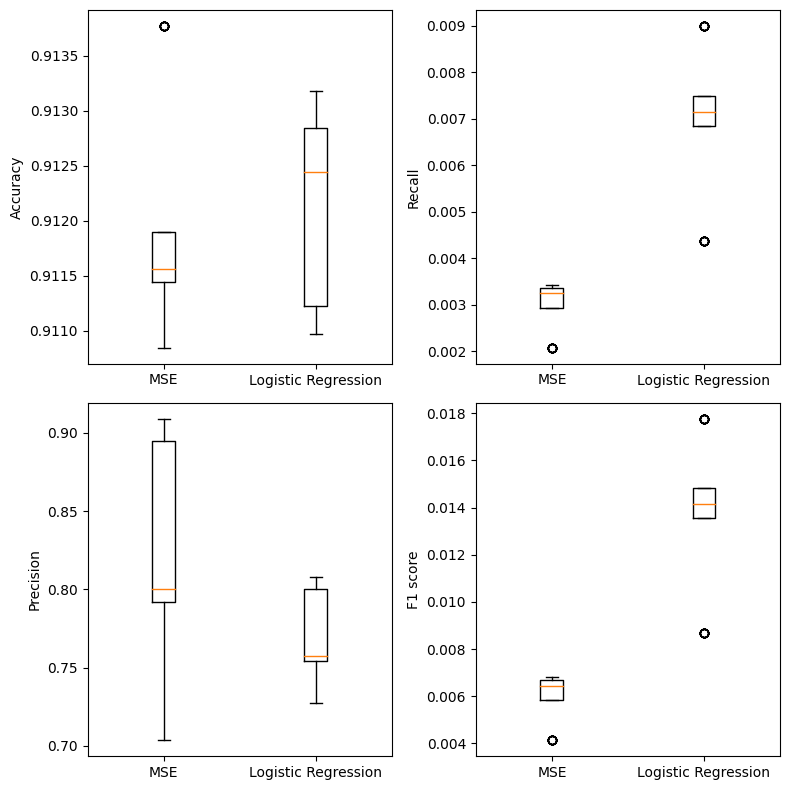

In [15]:
# plt.rcParams['figure.figsize'] = [10, 5]
fig, axs = plt.subplots(2, 2, figsize = (8, 8))

# Combine the accuracies into a list of lists
accuracies = [mse_accuracies, logreg_unbalanced_accuracies]
recalls = [mse_recalls, logreg_unbalanced_recalls]
precisions = [mse_precisions, logreg_unbalanced_precisions]
f1_scores = [mse_f1_scores, logreg_unbalanced_f1_scores]

labels = ['MSE', 'Logistic Regression']

axs[0][0].boxplot(accuracies, vert = True, labels = labels)
axs[0][0].set_ylabel('Accuracy')

axs[0][1].boxplot(recalls, vert = True, labels = labels)
axs[0][1].set_ylabel('Recall')

axs[1][0].boxplot(precisions, vert = True, labels = labels)
axs[1][0].set_ylabel('Precision')

axs[1][1].boxplot(f1_scores, vert = True, labels = labels)
axs[1][1].set_ylabel('F1 score')

# Display the plot
plt.tight_layout()

### Observations from Model 1 and 2

<u>Accuracy and other test metrics</u>
- High accuracy but very poor accuracy, recall and F1 score.
- Due to imbalance in dataset with most observations being 0 hence, high accuracy.

<u>MSE loss vs. Logistic Regression loss</u>
- MSE is less able to discriminate between positive and negative samples, as depicted by the lower median Recall, and F1 score. It is able to achieve higher Accuracy and Precision as it is predicting the majority class more often.
- Observing the summary statistics of the outputted values for MSE loss may not be suitable for classification where the output is the probability that a sample belongs to either the positive and negative class. 

<u>Follow-up</u>
- To allow the model to fit the train-validation data set better, we would downsample data such that data proportions are ~60/40. Current data proportion is ~91/9.
- Logistic regression loss would be used instead of MSE loss for the next few models.

### Downsample dataset

In [16]:
negative_class_cnt = np.sum(y_train == 0)
positive_class_cnt = np.sum(y_train == 1)

print(f'No. of negative samples: {negative_class_cnt}')
print(f'No. of positive samples: {positive_class_cnt}')
print(f'Total no. of samples: {y_train.shape[0]}')
print(f'Out of {y_train.shape[0]} observations, {(negative_class_cnt/(negative_class_cnt + positive_class_cnt))*100}% of observations are from negative class.')

No. of negative samples: 299160
No. of positive samples: 28975
Total no. of samples: 328135
Out of 328135 observations, 91.1697929205967% of observations are from negative class.


In [17]:
import math

def downsample_ds(x_train, y_train, pos_proportion = 0.5):
    
    """Downsamples the data to achieve a desired proportion of observations of the different classes.

    Args:
        x_train: numpy array of x_train data with shape (N, D)
        x_test: numpy array of x_test data with shape (N, D)
        y_train: numpy array of y_train data with shape (N,)
        pos_proportion: desired proportion of observations from positive class
        
    Returns:
        x_train, x_test and y_train with the desired proportions
    """    
    
    # Get number of positive and negative observations
    num_positive_obs = np.sum(y_train == 1)
    num_negative_obs = math.floor((num_positive_obs/pos_proportion) - num_positive_obs)
 
    # Get the positive observations
    positive_obs_idxs = np.where(y_train == 1)[0]
    x_sampled_positive_obs = x_train[positive_obs_idxs]
    y_sampled_positive_obs = y_train[positive_obs_idxs]
   
    # Get the negative observations
    # Randomly permutate the indexes of negative observations
    negative_obs_idxs = np.where(y_train == 0)[0]
    np.random.shuffle(negative_obs_idxs)
    
    # Get the desired numberof negative observations
    sampled_negative_obs_idxs = negative_obs_idxs[:num_negative_obs]
    x_sampled_negative_obs = x_train[sampled_negative_obs_idxs] 
    y_sampled_negative_obs = y_train[sampled_negative_obs_idxs]
    
    # Combine positive and negative samples to get downsampled dataset
    x_train_downsampled = np.append(x_sampled_positive_obs, x_sampled_negative_obs, axis = 0)
    y_train_downsampled = np.append(y_sampled_positive_obs, y_sampled_negative_obs)
    
    return x_train_downsampled, y_train_downsampled

In [18]:
x_train_downsampled, y_train_downsampled = downsample_ds(x_train_np, y_train)

negative_class_cnt = np.sum(y_train_downsampled == 0)
positive_class_cnt = np.sum(y_train_downsampled == 1)

print(f'No. of negative samples: {negative_class_cnt}')
print(f'No. of positive samples: {positive_class_cnt}')
print(f'Total no. of samples: {y_train_downsampled.shape[0]}')
print(f'Out of {y_train_downsampled.shape[0]} observations, {(negative_class_cnt/(negative_class_cnt + positive_class_cnt))*100}% of observations are from negative class.')

No. of negative samples: 28975
No. of positive samples: 28975
Total no. of samples: 57950
Out of 57950 observations, 50.0% of observations are from negative class.


## 4. Model 3: Logistic Regression with GD using downsampled dataset

In [19]:
'''Test logistic regression function'''

# Build k indices
k_indices = build_k_indices(y_train_downsampled, num_folds)

logreg_balanced_train_losses = []
logreg_balanced_test_losses = []
logreg_balanced_accuracies = []
logreg_balanced_recalls = []
logreg_balanced_precisions = []
logreg_balanced_f1_scores = []

_iter = 0

for epoch_num in range(epochs):
    for fold_num in range(num_folds):
        
        
        # Instantiate model
        model = LogReg_Model('logreg_gd', logistic_regression, calculate_logreg_loss)
        
        # Train model
        tr_loss, te_loss = cross_validation(y_train_downsampled, x_train_downsampled,
                                            k_indices, fold_num, model)
        
        # Get train and test split
        train_x, train_y, test_x, test_y = get_kfold_train_test(y_train_downsampled,
                                                                x_train_downsampled, k_indices, fold_num)
         
        # Predict and get metrics
        test_y_pred = model.predict(test_x)
        
        acc = model.calc_acc(test_y, test_y_pred)
        recall, precision, weighted_f1 = model.calc_metrics(test_y, test_y_pred)
        
        logreg_balanced_train_losses.append(tr_loss)
        logreg_balanced_test_losses.append(te_loss)
        logreg_balanced_accuracies.append(acc)
        logreg_balanced_recalls.append(recall)
        logreg_balanced_precisions.append(precision)
        logreg_balanced_f1_scores.append(weighted_f1)
        
        if _iter > 0 and _iter % print_every == 0:
            print(f'Iter no: {_iter}, train loss: {logreg_balanced_train_losses[_iter]}, test loss: {logreg_balanced_test_losses[_iter]}, accuracy: {logreg_balanced_accuracies[_iter]}, recalls: {logreg_balanced_recalls[_iter]}, precisions: {logreg_balanced_precisions[_iter]}, f1: {logreg_balanced_f1_scores[_iter]}')
        _iter += 1

Iter no: 6, train loss: 0.5165186221671293, test loss: 0.5166245371002123, accuracy: 0.7484900776531492, recalls: 0.7571379428964569, precisions: 0.7454699407281964, f1: 0.7512586398156839
Iter no: 12, train loss: 0.51677615098785, test loss: 0.5154867455509522, accuracy: 0.7499568593615186, recalls: 0.7502588885053504, precisions: 0.7497412901000345, f1: 0.75
Iter no: 18, train loss: 0.5158553174640369, test loss: 0.5185315363029381, accuracy: 0.7482312338222605, recalls: 0.7490060501296456, precisions: 0.7471977927228832, f1: 0.7481008287292819
Iter no: 24, train loss: 0.5163101162424397, test loss: 0.5168060402575082, accuracy: 0.7487489214840379, recalls: 0.7567614125753661, precisions: 0.745460716103852, f1: 0.7510685587279877
Iter no: 30, train loss: 0.5167946696107107, test loss: 0.5151750756988669, accuracy: 0.7542709232096635, recalls: 0.7607754890081357, precisions: 0.7498720354888244, f1: 0.7552844131294038
Iter no: 36, train loss: 0.5165186221671293, test loss: 0.5166245371

In [22]:
np.save('results/logreg_balanced/train_losses.npy', np.array(logreg_balanced_train_losses))
np.save('results/logreg_balanced/test_losses.npy', np.array(logreg_balanced_test_losses))
np.save('results/logreg_balanced/accuracies.npy', np.array(logreg_balanced_accuracies))
np.save('results/logreg_balanced/recalls.npy', np.array(logreg_balanced_recalls))
np.save('results/logreg_balanced/precisions.npy', np.array(logreg_balanced_precisions))
np.save('results/logreg_balanced/f1_scores.npy', np.array(logreg_balanced_f1_scores))

In [88]:
logreg_balanced_accuracies = np.load('results/logreg_balanced/accuracies.npy')
logreg_balanced_precisions = np.load('results/logreg_balanced/precisions.npy')
logreg_balanced_recalls = np.load('results/logreg_balanced/recalls.npy')
logreg_balanced_f1_scores = np.load('results/logreg_balanced/f1_scores.npy')

print(f'Validation Accuracies, mean: {np.mean(logreg_balanced_accuracies)}, std: {np.std(logreg_balanced_accuracies)}')
print(f'Validation Precisions, mean: {np.mean(logreg_balanced_precisions)}, std: {np.std(logreg_balanced_precisions)}')
print(f'Validation Recalls, mean: {np.mean(logreg_balanced_recalls)}, std: {np.std(logreg_balanced_recalls)}')
print(f'Validation F1 scores, mean: {np.mean(logreg_balanced_f1_scores)}, std: {np.std(logreg_balanced_f1_scores)}')

Validation Accuracies, mean: 0.749939603106126, std: 0.0022449055210284007
Validation Precisions, mean: 0.7475483550287582, std: 0.0019498405741593865
Validation Recalls, mean: 0.7547879566229909, std: 0.004454445165373981
Validation F1 scores, mean: 0.7511424880804715, std: 0.0023550571334225775


## Bias-Variance Decomposition

Using many permutations of the downsampled data, we observe a large sample of predictions. We then derive the bias and variance of the model through observing the confusion matrix.

- Bias:
    - Definition: Predicted data points are close to the target.
    - In context of classification: How well is model able to predict the correct label? This is measured by the absolute value of Accuracy and F1 score where a score closer to 1 indicates lower bias.

- Variance:
    - Definition: Predicted data points are consistent. Small changes to estimate with changes to training dataset
    - In context of classification: How consistent are the predictions across the randomised datasets? This is measured by the variance of the received Accuracy and F1 score metrics across randomised datasets.
    
Moving forward, let's test out on randomly generated downsampled datasets and observe the distribution of tp/tn/fp/fn respectively. A learning curve between train and validation dataset is also plotted to see how welll the model fits.

In [24]:
'''Test logistic regression function'''

# Build k indices
k_indices = build_k_indices(y_train_downsampled, num_folds)

logreg_balanced_train_losses = []
logreg_balanced_test_losses = []

logreg_balanced_tr_accuracies = []
logreg_balanced_te_accuracies = []

logreg_balanced_tr_recalls = []
logreg_balanced_te_recalls = []

logreg_balanced_tr_precisions = []
logreg_balanced_te_precisions = []

logreg_balanced_tr_f1_scores = []
logreg_balanced_te_f1_scores = []

_iter = 0

for epoch_num in range(epochs):
    for fold_num in range(num_folds):
        
        # Instantiate model
        model = LogReg_Model('logreg_gd', logistic_regression, calculate_logreg_loss)
        
        # Train model
        tr_loss, te_loss = cross_validation(y_train_downsampled, x_train_downsampled,
                                            k_indices, fold_num, model)
        
        # Get train and test split
        train_x, train_y, test_x, test_y = get_kfold_train_test(y_train_downsampled,
                                                                x_train_downsampled, k_indices, fold_num)
         
        logreg_balanced_train_losses.append(tr_loss)
        logreg_balanced_test_losses.append(te_loss)
            
        # Predict and get metrics
        train_y_pred = model.predict(train_x)
        acc = model.calc_acc(train_y, train_y_pred)
        recall, precision, weighted_f1 = model.calc_metrics(train_y, train_y_pred)
        logreg_balanced_tr_accuracies.append(acc)
        logreg_balanced_tr_recalls.append(recall)
        logreg_balanced_tr_precisions.append(precision)
        logreg_balanced_tr_f1_scores.append(weighted_f1)

        test_y_pred = model.predict(test_x)
        acc = model.calc_acc(test_y, test_y_pred)
        recall, precision, weighted_f1 = model.calc_metrics(test_y, test_y_pred)  
        logreg_balanced_te_accuracies.append(acc)
        logreg_balanced_te_recalls.append(recall)
        logreg_balanced_te_precisions.append(precision)
        logreg_balanced_te_f1_scores.append(weighted_f1)

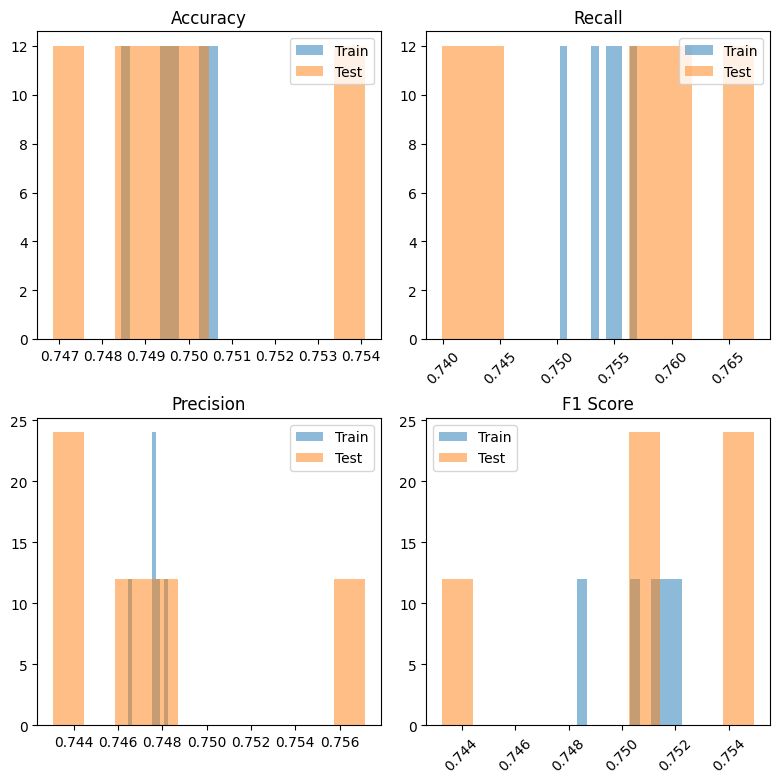

In [25]:
# plt.rcParams['figure.figsize'] = [10, 5]
fig, axs = plt.subplots(2, 2, figsize = (8,8))

# Combine the accuracies into a list of lists
accs = [logreg_balanced_tr_accuracies, logreg_balanced_te_accuracies]
recalls = [logreg_balanced_tr_recalls, logreg_balanced_te_recalls]
precisions = [logreg_balanced_tr_precisions, logreg_balanced_te_precisions]
f1_scores = [logreg_balanced_tr_f1_scores, logreg_balanced_te_f1_scores]

labels = ['Train', 'Test']

axs[0][0].title.set_text('Accuracy')
axs[0][0].hist(logreg_balanced_tr_accuracies, label='Train', alpha=.5)
axs[0][0].hist(logreg_balanced_te_accuracies, label="Test", alpha=.5)
axs[0][0].legend()

axs[0][1].title.set_text('Recall')
axs[0][1].hist(logreg_balanced_tr_recalls, label='Train', alpha=.5)
axs[0][1].hist(logreg_balanced_te_recalls, label="Test", alpha=.5)
axs[0][1].tick_params(axis='x', rotation=45)
axs[0][1].legend()

axs[1][0].title.set_text('Precision')
axs[1][0].hist(logreg_balanced_tr_precisions, label='Train', alpha=.5)
axs[1][0].hist(logreg_balanced_te_precisions, label="Test", alpha=.5)
axs[1][0].legend()

axs[1][1].title.set_text('F1 Score')
axs[1][1].hist(logreg_balanced_tr_f1_scores, label='Train', alpha=.5)
axs[1][1].hist(logreg_balanced_te_f1_scores, label="Test", alpha=.5)
axs[1][1].tick_params(axis='x', rotation=45)
axs[1][1].legend()

plt.tight_layout()

In [85]:
# Get mean and variance for each metric
def get_summary_stats(arr):
    
    """Get summary statistics for an array of observed metric
    
    Args:
        arr: array of values for observed metric
    
    Returns:
        mean: mean of array values
        std: standard deviation of array values
    """
    
    np_arr = np.array(arr)
    return np.mean(np_arr), np.std(np_arr)

print(f'Validation accuracy, mean: {get_summary_stats(logreg_balanced_te_accuracies)[0]}, std. dev: {get_summary_stats(logreg_balanced_te_accuracies)[1]}')
print(f'Validation recall, mean: {get_summary_stats(logreg_balanced_te_recalls)[0]}, std. dev: {get_summary_stats(logreg_balanced_te_recalls)[1]}')
print(f'Validation precision, mean: {get_summary_stats(logreg_balanced_te_precisions)[0]}, std. dev: {get_summary_stats(logreg_balanced_te_precisions)[1]}')
print(f'Validation f1-score, mean: {get_summary_stats(logreg_balanced_te_f1_scores)[0]}, std. dev: {get_summary_stats(logreg_balanced_te_f1_scores)[1]}')

Validation accuracy, mean: 0.749853321829163, std. dev: 0.00238323818600191
Validation recall, mean: 0.754146970092599, std. dev: 0.010186645841224987
Validation precision, mean: 0.7477683209431945, std. dev: 0.0049776636918025365
Validation f1-score, mean: 0.7508821096168384, std. dev: 0.004146061505734305


In [32]:
# Generate learning curve

# Instantiate model
model = LogReg_Model('logreg_gd', logistic_regression, calculate_logreg_loss)

# Get train and test split
train_x, train_y, test_x, test_y = get_kfold_train_test(y_train_downsampled,
                                                        x_train_downsampled, k_indices, fold_num)

# Initialise initial weights
initial_w = np.zeros((train_x.shape[1],), dtype = np.float64)
train_loss, train_acc, train_f1, test_loss, test_acc, test_f1 = model.train_withlc(train_y, train_x, test_y, test_x,
                                                                                   initial_w, 100, 0.1)

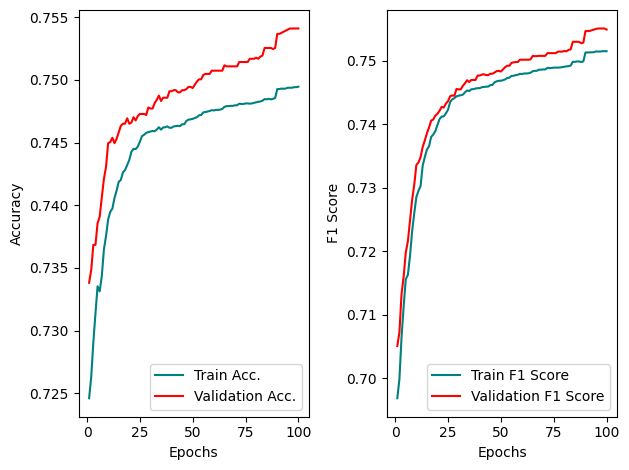

In [47]:
fig, axs = plt.subplots(1, 2)

epochs = [(i + 1) for i in range(len(train_loss))]

axs[0].plot(epochs, train_acc, color = 'teal', label = 'Train Acc.')
axs[0].plot(epochs, test_acc, color = 'red', label = 'Validation Acc.')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')

axs[1].plot(epochs, train_f1, color = 'teal', label = 'Train F1 Score')
axs[1].plot(epochs, test_f1, color = 'red', label = 'Validation F1 Score')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('F1 Score')
axs[1].legend(loc='lower right')

plt.tight_layout()

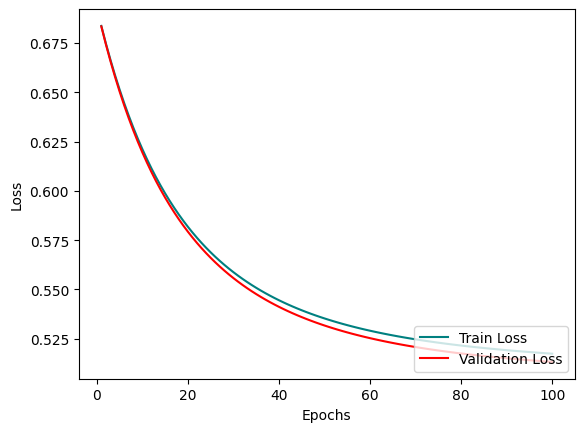

In [46]:
plt.plot(epochs, train_loss, color = 'teal', label = 'Train Loss')
plt.plot(epochs, test_loss, color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

### Observations

<u>Low variance, High Bias</u>
- Low Variance: Achieved metrics have a very low standard deviation across different randomised downsampled datasets. Hence, low variance.
- High Bias: The model is able to fit the train data set well and generalise well to the validation data set. The received metrics for both train and validation splits are very close. For F1 score, a bulk of accuracy and F1 scores obtained differ from each other by only 0.002 and 0.005 at most respectively. Moreover, the closeness of values in both train and validation F1 scores as shown in the learning curves support this claim.

<u>Test Performance</u>
- However, testing our model on the train dataset yield a much lower F1 score of 0.376 and an Accuracy of 0.808. The huge discrepancy between the F1 scores indicate severe overfitting on the train-validation dataset and the model is not able to generalise well on unseen test data. This is possibly due to the fact that the train-validation data set was downsampled.

<u>Follow-up</u>

- Moving forward, we aim to fit the model better on the test data set by taking the following steps.

- Step 1 - Adjustments to dataset: Reduction in number of features used in design matrix. This is done by removing variables that only target a specific age group, have high codependency with other columns.

- Step 2 - Regularisation: Add L2 regularisation to deal with possible overfitting by ensuring that the trained weights are kept small.

## 5. Model 4: Logistic Regression with GD using downsampled, feature reduced dataset

In [48]:
from data_loader import *

x_train_np = load_x_data('datasets/updated_ds/x_train.npy')
x_test_np = load_x_data('datasets/updated_ds/x_test.npy')

print(x_train_np.shape) # (328135, 19)
print(x_test_np.shape) # (109379, 19)

(328135, 19)
(109379, 19)


In [49]:
x_train_downsampled, y_train_downsampled = downsample_ds(x_train_np, y_train)

negative_class_cnt = np.sum(y_train_downsampled == 0)
positive_class_cnt = np.sum(y_train_downsampled == 1)

print(f'No. of negative samples: {negative_class_cnt}')
print(f'No. of positive samples: {positive_class_cnt}')
print(f'Total no. of samples: {y_train_downsampled.shape[0]}')
print(f'Out of {y_train_downsampled.shape[0]} observations, {(negative_class_cnt/(negative_class_cnt + positive_class_cnt))*100}% of observations are from negative class.')

No. of negative samples: 28975
No. of positive samples: 28975
Total no. of samples: 57950
Out of 57950 observations, 50.0% of observations are from negative class.


In [51]:
'''Test logistic regression function'''

print_every = 6
epochs = 12
num_folds = 5

#logreg_train_losses = []
#logreg_test_losses = []
logreg_train_accs = []
logreg_train_recalls = []
logreg_train_precisions = []
logreg_train_f1_scores = []

logreg_test_accs = []
logreg_test_recalls = []
logreg_test_precisions = []
logreg_test_f1_scores = []

_iter = 0

for epoch_num in range(epochs):
    
    # Instantiate model
    model = LogReg_Model('logreg_gd', logistic_regression, calculate_logreg_loss)
        
    # Get a new downsampled dataset
    x_train_downsampled, y_train_downsampled = downsample_ds(x_train_np, y_train, 0.5)
    
    # Build k indices
    k_indices = build_k_indices(y_train_downsampled, num_folds)

    for fold_num in range(num_folds):
        
        # Train model
        tr_loss, te_loss = cross_validation(y_train_downsampled, x_train_downsampled,
                                            k_indices, fold_num, model)
        
        # Predict and get metrics
        train_x, train_y, test_x, test_y = get_kfold_train_test(y_train_downsampled,
                                                                x_train_downsampled, k_indices, fold_num)

        # Get predictions and metrics for train dataset
        train_y_pred = model.predict(train_x)
        train_acc = model.calc_acc(train_y, train_y_pred)
        train_recall, train_precision, train_weighted_f1 = model.calc_metrics(train_y, train_y_pred)
        
        logreg_train_accs.append(train_acc)
        logreg_train_recalls.append(train_recall)
        logreg_train_precisions.append(train_precision)
        logreg_train_f1_scores.append(train_weighted_f1)
       
        # Get predictions and metrics for test dataset
        test_y_pred = model.predict(test_x)
        test_acc = model.calc_acc(test_y, test_y_pred)
        test_recall, test_precision, test_weighted_f1 = model.calc_metrics(test_y, test_y_pred)
        
        logreg_test_accs.append(test_acc)
        logreg_test_recalls.append(test_recall)
        logreg_test_precisions.append(test_precision)
        logreg_test_f1_scores.append(test_weighted_f1)
        
        if _iter > 0 and _iter % print_every == 0:
            print(f'Iter no: {_iter}, train loss: {tr_loss}, test loss: {te_loss}, test accuracy: {logreg_test_accs[_iter]}, test recall: {logreg_test_recalls[_iter]}, test precision: {logreg_test_precisions[_iter]}, test f1: {logreg_test_f1_scores[_iter]}')
        _iter += 1

Iter no: 6, train loss: 0.522369029479424, test loss: 0.5224565305779539, test accuracy: 0.747886108714409, test recall: 0.7590215128383068, test precision: 0.740521327014218, test f1: 0.7496572995202193
Iter no: 12, train loss: 0.5176900316328448, test loss: 0.5208475466282567, test accuracy: 0.7499568593615186, test recall: 0.7574733997635534, test precision: 0.7541617622330586, test f1: 0.755813953488372
Iter no: 18, train loss: 0.519754658932099, test loss: 0.5230927310240802, test accuracy: 0.74702329594478, test recall: 0.7549577513364373, test precision: 0.7434199354729156, test f1: 0.7491444216290212
Iter no: 24, train loss: 0.5220160411646115, test loss: 0.5239568817553922, test accuracy: 0.7458153580672994, test recall: 0.7596685082872928, test precision: 0.7389989922741015, test f1: 0.7491912140303082
Iter no: 30, train loss: 0.5208899765909496, test loss: 0.5182617361824161, test accuracy: 0.7524590163934426, test recall: 0.7564415041782729, test precision: 0.74720550300945

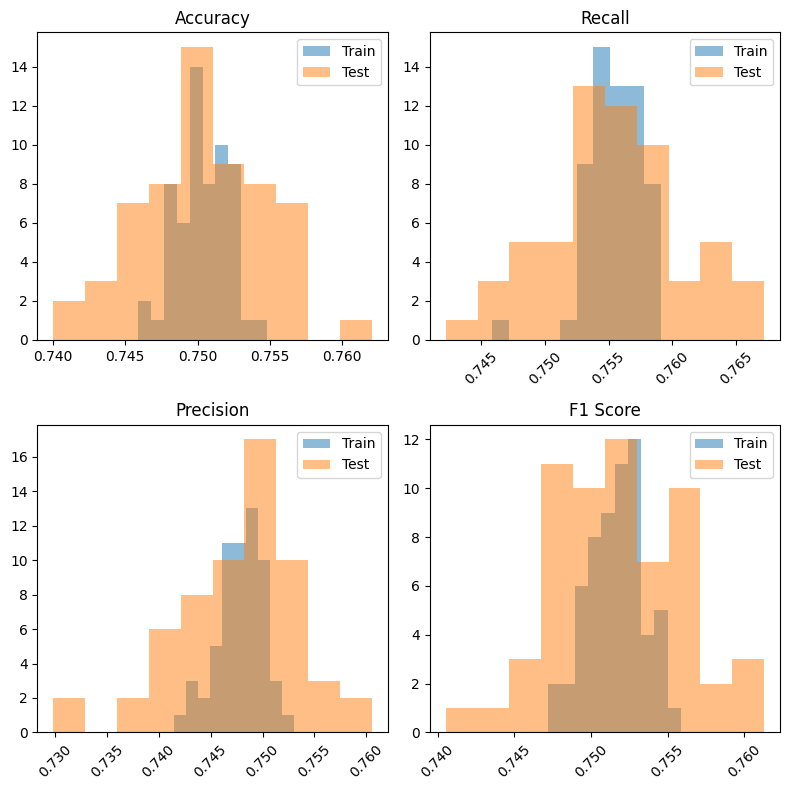

In [52]:
# plt.rcParams['figure.figsize'] = [10, 5]
fig, axs = plt.subplots(2, 2, figsize = (8,8))

# Combine the accuracies into a list of lists
accs = [logreg_train_accs, logreg_test_accs]
recalls = [logreg_train_recalls, logreg_test_recalls]
precisions = [logreg_train_precisions, logreg_test_precisions]
f1_scores = [logreg_train_f1_scores, logreg_test_f1_scores]

labels = ['Train', 'Test']

axs[0][0].title.set_text('Accuracy')
axs[0][0].hist(logreg_train_accs, label='Train', alpha=.5)
axs[0][0].hist(logreg_test_accs, label="Test", alpha=.5)
axs[0][0].legend()

axs[0][1].title.set_text('Recall')
axs[0][1].hist(logreg_train_recalls, label='Train', alpha=.5)
axs[0][1].hist(logreg_test_recalls, label="Test", alpha=.5)
axs[0][1].tick_params(axis='x', rotation=45)
axs[0][1].legend()

axs[1][0].title.set_text('Precision')
axs[1][0].hist(logreg_train_precisions, label='Train', alpha=.5)
axs[1][0].hist(logreg_test_precisions, label="Test", alpha=.5)
axs[1][0].tick_params(axis='x', rotation=45)
axs[1][0].legend()

axs[1][1].title.set_text('F1 Score')
axs[1][1].hist(logreg_train_f1_scores, label='Train', alpha=.5)
axs[1][1].hist(logreg_test_f1_scores, label="Test", alpha=.5)
axs[1][1].tick_params(axis='x', rotation=45)
axs[1][1].legend()

plt.tight_layout()

In [84]:
print(f'Validation Accuracy, mean: {np.mean(np.array(logreg_test_accs))}, std : {np.std(np.array(logreg_test_accs))}')
print(f'Validation Recall, recall: {np.mean(np.array(logreg_test_recalls))}, std: {np.std(np.array(logreg_test_recalls))}')
print(f'Validation Precisions, acc: {np.mean(np.array(logreg_test_precisions))}, std: {np.std(np.array(logreg_test_precisions))}')
print(f'Validation F1 score, f1-score: {np.mean(np.array(logreg_test_f1_scores))}, std: {np.std(np.array(logreg_test_f1_scores))}')

Validation Accuracy, mean: 0.7503293068737418, std : 0.0041276819717893
Validation Recall, recall: 0.7554419722293751, std: 0.005318492653597522
Validation Precisions, acc: 0.7478121311461666, std: 0.005765473597000327
Validation F1 score, f1-score: 0.7515901532975013, std: 0.004207638343342737


In [54]:
np.save('results/logreg_final_ds/accuracies.npy', np.array(logreg_test_accs))
np.save('results/logreg_final_ds/recalls.npy', np.array(logreg_test_recalls))
np.save('results/logreg_final_ds/precisions.npy', np.array(logreg_test_precisions))
np.save('results/logreg_final_ds/f1_scores.npy', np.array(logreg_test_f1_scores))

In [55]:
# Generate learning curve

# Instantiate model
model = LogReg_Model('logreg_gd', logistic_regression, calculate_logreg_loss)

# Get train and test split
train_x, train_y, test_x, test_y = get_kfold_train_test(y_train_downsampled,
                                                        x_train_downsampled, k_indices, fold_num)

# Initialise initial weights
initial_w = np.zeros((train_x.shape[1],), dtype = np.float64)
train_loss, train_acc, train_f1, test_loss, test_acc, test_f1 = model.train_withlc(train_y, train_x, test_y, test_x,
                                                                                   initial_w, 100, 0.1)

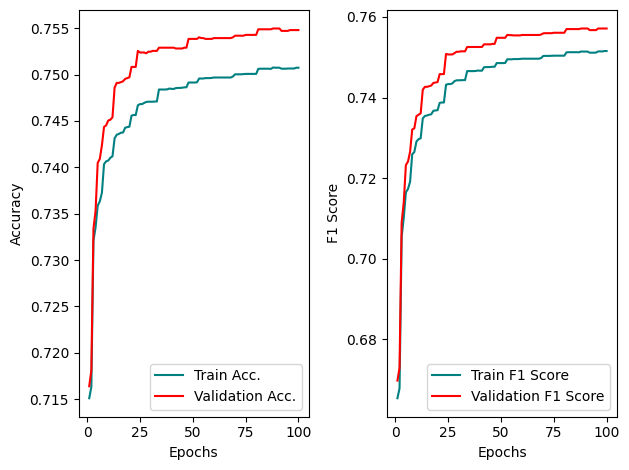

In [56]:
fig, axs = plt.subplots(1, 2)

epochs = [(i + 1) for i in range(len(train_loss))]

axs[0].plot(epochs, train_acc, color = 'teal', label = 'Train Acc.')
axs[0].plot(epochs, test_acc, color = 'red', label = 'Validation Acc.')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')

axs[1].plot(epochs, train_f1, color = 'teal', label = 'Train F1 Score')
axs[1].plot(epochs, test_f1, color = 'red', label = 'Validation F1 Score')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('F1 Score')
axs[1].legend(loc='lower right')

plt.tight_layout()

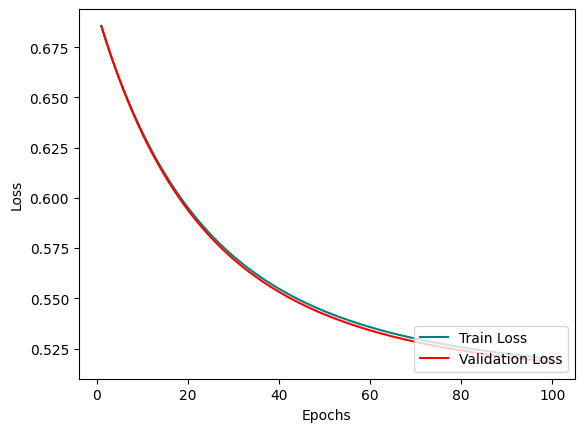

In [57]:
plt.plot(epochs, train_loss, color = 'teal', label = 'Train Loss')
plt.plot(epochs, test_loss, color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

### Observations

Model 4's performance on the train-validation data set is almost similar to Model 3's. While Model 4 was slightly better at identifying the true positive samples (as seen by the little increase in Recall and F1), the problem of overfitting was not solved as there was still a large discrepancy with the results obtained with the Test dataset.

This concludes that the Feature Reduction performed above is not significant enough to solve the problem of overfitting. Moving on, L2 regularisation would be performed instead.

## 6. Model 5: Regularised Logistic Regression with GD using downsampled, feature reduced dataset
Cross validation is first performed across the different lambda values to select the optimal lambda.

In [59]:
'''Test logistic regression function'''

# Ran with Trial 1 dataset
logreg_reg_train_losses = []
logreg_reg_train_accs = []
logreg_reg_train_recalls = []
logreg_reg_train_precisions = []
logreg_reg_train_f1_scores = []

logreg_reg_test_losses = []
logreg_reg_test_accs = []
logreg_reg_test_recalls = []
logreg_reg_test_precisions = []
logreg_reg_test_f1_scores = []

# Get a new downsampled dataset
x_train_downsampled, y_train_downsampled = downsample_ds(x_train_np, y_train)
# Build k indices
num_folds = 5
k_indices = build_k_indices(y_train_downsampled, num_folds)

# Lambda search space
lambdas = np.logspace(-2, 1.25, 40)
for lambda_idx in range(lambdas.shape[0]):
    
    tr_loss, tr_acc, tr_precision, tr_recall, tr_weighted_f1 = 0., 0., 0., 0., 0.
    te_loss, te_acc, te_precision, te_recall, te_weighted_f1 = 0., 0., 0., 0., 0.
    
    for fold_num in range(num_folds):
        
        # Instantiate model
        model = LogReg_WithReg_Model('logreg_withreg_gd', reg_logistic_regression, calculate_logreg_loss)

        # Train model
        train_loss, test_loss = cross_validation(y_train_downsampled, x_train_downsampled,
                                            k_indices, fold_num, model, lambdas[lambda_idx])
        
        # Predict and get metrics
        train_x, train_y, test_x, test_y = get_kfold_train_test(y_train_downsampled,
                                                                x_train_downsampled, k_indices, fold_num)

        # Get predictions and metrics for train dataset
        train_y_pred = model.predict(train_x)
        train_acc = model.calc_acc(train_y, train_y_pred)
        train_recall, train_precision, train_weighted_f1 = model.calc_metrics(train_y, train_y_pred)
        tr_loss += train_loss
        tr_acc += train_acc
        tr_recall += train_recall
        tr_precision += train_precision
        tr_weighted_f1 += train_weighted_f1
        
        # Get predictions and metrics for test dataset
        test_y_pred = model.predict(test_x)
        test_acc = model.calc_acc(test_y, test_y_pred)
        test_recall, test_precision, test_weighted_f1 = model.calc_metrics(test_y, test_y_pred)
        te_loss += test_loss
        te_acc += test_acc
        te_recall += test_recall
        te_precision += test_precision
        te_weighted_f1 += test_weighted_f1
    
    logreg_reg_train_losses.append(tr_loss/num_folds)
    logreg_reg_train_accs.append(tr_acc/num_folds)
    logreg_reg_train_recalls.append(tr_recall/num_folds)
    logreg_reg_train_precisions.append(tr_precision/num_folds)
    logreg_reg_train_f1_scores.append(tr_weighted_f1/num_folds)
    
    logreg_reg_test_losses.append(te_loss/num_folds)
    logreg_reg_test_accs.append(te_acc/num_folds)
    logreg_reg_test_recalls.append(te_recall/num_folds)
    logreg_reg_test_precisions.append(te_precision/num_folds)
    logreg_reg_test_f1_scores.append(te_weighted_f1/num_folds)

/home/cs_433_mlprojects/EPFL-Machine-Learning-JEC/utils.py:111: RuntimeWarning: overflow encountered in exp
  t = (np.exp(t))/ (1 + np.exp(t))
/home/cs_433_mlprojects/EPFL-Machine-Learning-JEC/utils.py:111: RuntimeWarning: invalid value encountered in divide
  t = (np.exp(t))/ (1 + np.exp(t))


In [60]:
def cross_validation_visualisation(ax, lambds, tr_vals, te_vals, metric_name):
    """visualization the curves of rmse_tr and rmse_te."""
    ax.semilogx(lambds, tr_vals, marker=".", color="b", label=f'train_{metric_name}')
    ax.semilogx(lambds, te_vals, marker=".", color="r", label=f'test_{metric_name}')
    ax.set_xlabel("lambda")
    ax.set_ylabel(metric_name)
    # plt.xlim(1e-4, 1)
    # ax.set_title("cross validation")  
    ax.legend(loc=1)
    ax.grid(True)

In [61]:
print(np.logspace(-2,1.25,40))

[1.00000000e-02 1.21152766e-02 1.46779927e-02 1.77827941e-02
 2.15443469e-02 2.61015722e-02 3.16227766e-02 3.83118685e-02
 4.64158883e-02 5.62341325e-02 6.81292069e-02 8.25404185e-02
 1.00000000e-01 1.21152766e-01 1.46779927e-01 1.77827941e-01
 2.15443469e-01 2.61015722e-01 3.16227766e-01 3.83118685e-01
 4.64158883e-01 5.62341325e-01 6.81292069e-01 8.25404185e-01
 1.00000000e+00 1.21152766e+00 1.46779927e+00 1.77827941e+00
 2.15443469e+00 2.61015722e+00 3.16227766e+00 3.83118685e+00
 4.64158883e+00 5.62341325e+00 6.81292069e+00 8.25404185e+00
 1.00000000e+01 1.21152766e+01 1.46779927e+01 1.77827941e+01]


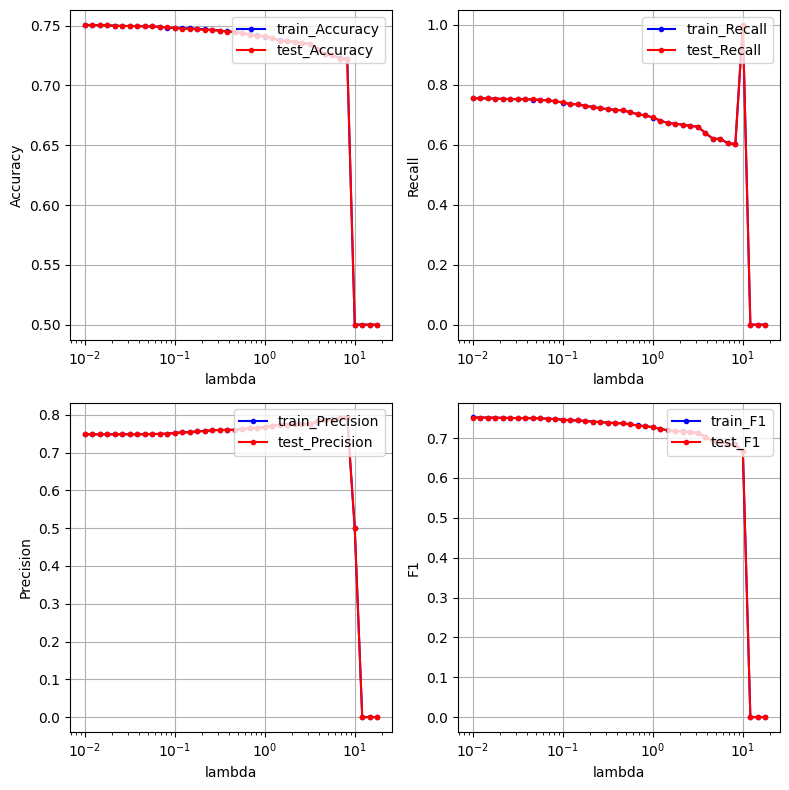

In [62]:
fig, axs = plt.subplots(2, 2, figsize = (8,8))

cross_validation_visualisation(axs[0,0], lambdas, logreg_reg_train_accs, logreg_reg_test_accs, 'Accuracy')
cross_validation_visualisation(axs[0,1], lambdas, logreg_reg_train_recalls, logreg_reg_test_recalls, 'Recall')
cross_validation_visualisation(axs[1,0], lambdas, logreg_reg_train_precisions, logreg_reg_test_precisions, 'Precision')
cross_validation_visualisation(axs[1,1], lambdas, logreg_reg_train_f1_scores, logreg_reg_test_f1_scores, 'F1')

plt.tight_layout()

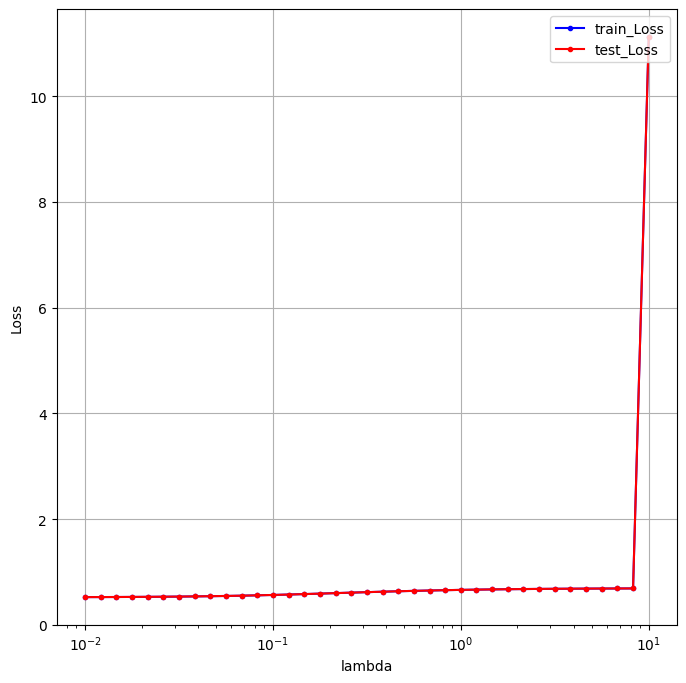

In [63]:
fig, axs = plt.subplots(1, 1, figsize = (8,8))

cross_validation_visualisation(axs, lambdas, logreg_reg_train_losses, logreg_reg_test_losses, 'Loss')

#### Choice of lambda

Considering the small variance of the evaluation metrics and the huge discrepancy between the validation F1 score and test F1 score, a strong degree of overfitting is present.

To help circumvent overfitting in the model, the value of lambda_ was carefully selected as 8.25. Lambda_ values smaller than 8.25 were not large enough to help deal with the strong overfitting of the model on the train-validation set while values larger than 8.25 caused the model to underfit instead.

In [66]:
# choosing lambda_ = 8.25,
'''Test logistic regression function'''

print_every = 6
epochs = 12
num_folds = 5

#logreg_train_losses = []
#logreg_test_losses = []
logreg_withreg_train_accs = []
logreg_withreg_train_recalls = []
logreg_withreg_train_precisions = []
logreg_withreg_train_f1_scores = []

logreg_withreg_test_accs = []
logreg_withreg_test_recalls = []
logreg_withreg_test_precisions = []
logreg_withreg_test_f1_scores = []

_iter = 0
lambda_ = 8.25

for epoch_num in range(epochs):
    
    # Instantiate model
    model = LogReg_WithReg_Model('logreg_withreg_gd', reg_logistic_regression, calculate_logreg_loss)

    # Get a new downsampled dataset
    x_train_downsampled, y_train_downsampled = downsample_ds(x_train_np, y_train)
    # Build k indices
    k_indices = build_k_indices(y_train_downsampled, num_folds)

    for fold_num in range(num_folds):
        
        # Train model
        tr_loss, te_loss = cross_validation(y_train_downsampled, x_train_downsampled,
                                            k_indices, fold_num, model, lambda_)
        
        # Predict and get metrics
        train_x, train_y, test_x, test_y = get_kfold_train_test(y_train_downsampled,
                                                                x_train_downsampled, k_indices, fold_num)

        # Get predictions and metrics for train dataset
        train_y_pred = model.predict(train_x)
        train_acc = model.calc_acc(train_y, train_y_pred)
        train_recall, train_precision, train_weighted_f1 = model.calc_metrics(train_y, train_y_pred)
        
        logreg_withreg_train_accs.append(train_acc)
        logreg_withreg_train_recalls.append(train_recall)
        logreg_withreg_train_precisions.append(train_precision)
        logreg_withreg_train_f1_scores.append(train_weighted_f1)
       
        # Get predictions and metrics for test dataset
        test_y_pred = model.predict(test_x)
        test_acc = model.calc_acc(test_y, test_y_pred)
        test_recall, test_precision, test_weighted_f1 = model.calc_metrics(test_y, test_y_pred)
        
        logreg_withreg_test_accs.append(test_acc)
        logreg_withreg_test_recalls.append(test_recall)
        logreg_withreg_test_precisions.append(test_precision)
        logreg_withreg_test_f1_scores.append(test_weighted_f1)
        
        if _iter > 0 and _iter % print_every == 0:
            print(f'Iter no: {_iter}, train loss: {tr_loss}, test loss: {te_loss}, test accuracy: {logreg_withreg_test_accs[_iter]}, test recall: {logreg_withreg_test_recalls[_iter]}, test precision: {logreg_withreg_test_precisions[_iter]}, test f1: {logreg_withreg_test_f1_scores[_iter]}')
        _iter += 1

Iter no: 6, train loss: 0.6885929494904929, test loss: 0.68847538592932, test accuracy: 0.7201898188093184, test recall: 0.5758572913058538, test precision: 0.8072347657198349, test f1: 0.672192459314667
Iter no: 12, train loss: 0.6885882722928548, test loss: 0.6886388878936381, test accuracy: 0.7125107851596204, test recall: 0.5654995730145175, test precision: 0.8077579897535985, test f1: 0.6652601969057665
Iter no: 18, train loss: 0.688623606500992, test loss: 0.6886427616129182, test accuracy: 0.7148403796376186, test recall: 0.570178448867536, test precision: 0.8059665292262915, test f1: 0.6678725756205406
Iter no: 24, train loss: 0.6886502390303971, test loss: 0.688726742697891, test accuracy: 0.7145815358067299, test recall: 0.5715031315240083, test precision: 0.7953995157384988, test f1: 0.665114395626645
Iter no: 30, train loss: 0.688627040608496, test loss: 0.6886259490957918, test accuracy: 0.7139775668679896, test recall: 0.5758614777987313, test precision: 0.799761904761904

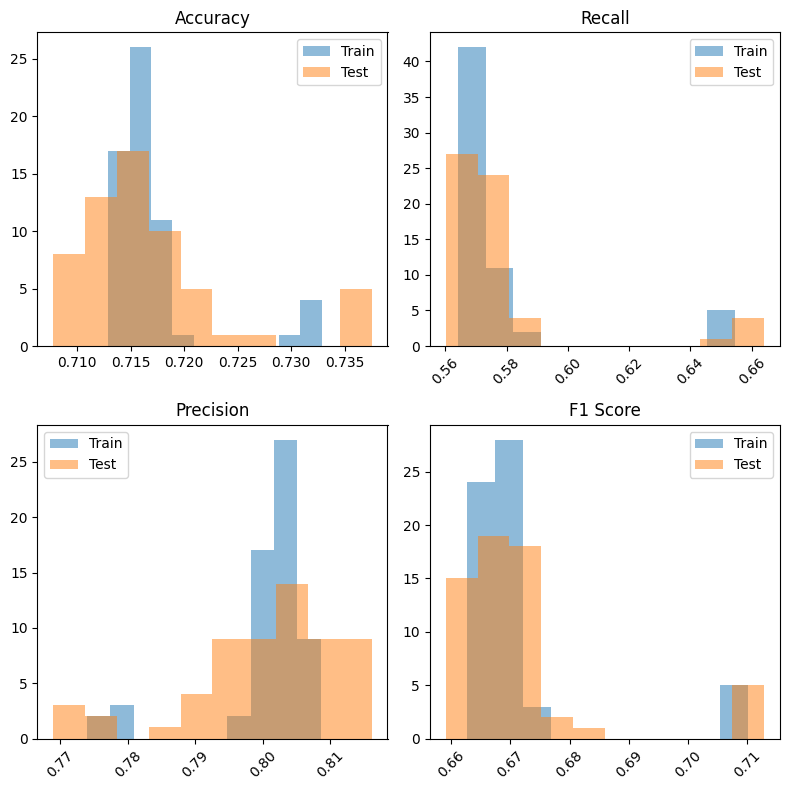

In [67]:
# plt.rcParams['figure.figsize'] = [10, 5]
fig, axs = plt.subplots(2, 2, figsize = (8,8))

# Combine the accuracies into a list of lists
accs = [logreg_withreg_train_accs, logreg_withreg_test_accs]
recalls = [logreg_withreg_train_recalls, logreg_withreg_test_recalls]
precisions = [logreg_withreg_train_precisions, logreg_withreg_test_precisions]
f1_scores = [logreg_withreg_train_f1_scores, logreg_withreg_test_f1_scores]

labels = ['Train', 'Test']

axs[0][0].title.set_text('Accuracy')
axs[0][0].hist(logreg_withreg_train_accs, label='Train', alpha=.5)
axs[0][0].hist(logreg_withreg_test_accs, label="Test", alpha=.5)
axs[0][0].legend()

axs[0][1].title.set_text('Recall')
axs[0][1].hist(logreg_withreg_train_recalls, label='Train', alpha=.5)
axs[0][1].hist(logreg_withreg_test_recalls, label="Test", alpha=.5)
axs[0][1].tick_params(axis='x', rotation=45)
axs[0][1].legend()

axs[1][0].title.set_text('Precision')
axs[1][0].hist(logreg_withreg_train_precisions, label='Train', alpha=.5)
axs[1][0].hist(logreg_withreg_test_precisions, label="Test", alpha=.5)
axs[1][0].tick_params(axis='x', rotation=45)
axs[1][0].legend()

axs[1][1].title.set_text('F1 Score')
axs[1][1].hist(logreg_withreg_train_f1_scores, label='Train', alpha=.5)
axs[1][1].hist(logreg_withreg_test_f1_scores, label="Test", alpha=.5)
axs[1][1].tick_params(axis='x', rotation=45)
axs[1][1].legend()

plt.tight_layout()

In [83]:
print(f'Validation Accuracy, mean: {np.mean(np.array(logreg_withreg_test_accs))}, std : {np.std(np.array(logreg_withreg_test_accs))}')
print(f'Validation Recall, recall: {np.mean(np.array(logreg_withreg_test_recalls))}, std: {np.std(np.array(logreg_withreg_test_recalls))}')
print(f'Validation Precisions, acc: {np.mean(np.array(logreg_withreg_test_precisions))}, std: {np.std(np.array(logreg_withreg_test_precisions))}')
print(f'Validation F1 score, f1-score: {np.mean(np.array(logreg_withreg_test_f1_scores))}, std: {np.std(np.array(logreg_withreg_test_f1_scores))}')

Validation Accuracy, mean: 0.7169988495829739, std : 0.007048842229281712
Validation Recall, recall: 0.5786791699812647, std: 0.025201963153198396
Validation Precisions, acc: 0.8005401446280118, std: 0.01101939165233237
Validation F1 score, f1-score: 0.6712934120674535, std: 0.013103528316179447


In [69]:
np.save('results/logreg_final_ds_withreg/accuracies.npy', np.array(logreg_withreg_test_accs))
np.save('results/logreg_final_ds_withreg/recalls.npy', np.array(logreg_withreg_test_recalls))
np.save('results/logreg_final_ds_withreg/precisions.npy', np.array(logreg_withreg_test_precisions))
np.save('results/logreg_final_ds_withreg/f1_scores.npy', np.array(logreg_withreg_test_f1_scores))

In [75]:
# Generate learning curve

# Instantiate model
model = LogReg_WithReg_Model('logreg_withreg_gd', logistic_regression, calculate_logreg_loss)

# Get train and test split
train_x, train_y, test_x, test_y = get_kfold_train_test(y_train_downsampled,
                                                        x_train_downsampled, k_indices, fold_num)

# Initialise initial weights
initial_w = np.zeros((train_x.shape[1],), dtype = np.float64)
lambda_ = 8.25
train_loss, train_acc, train_f1, test_loss, test_acc, test_f1 = model.train_withlc(train_y, train_x, test_y, test_x, initial_w, 100, lambda_, 0.1)

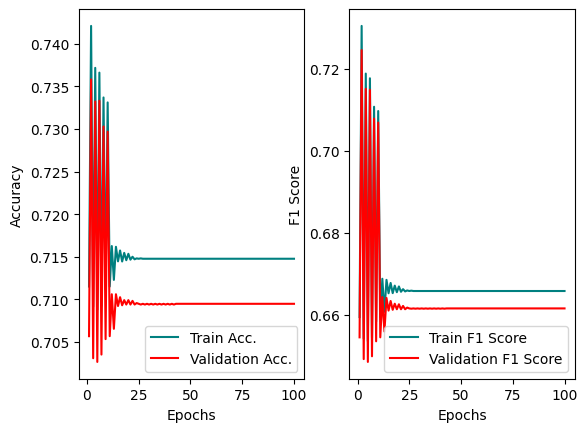

In [76]:
fig, axs = plt.subplots(1, 2)

epochs = [(i + 1) for i in range(len(train_loss))]

axs[0].plot(epochs, train_acc, color = 'teal', label = 'Train Acc.')
axs[0].plot(epochs, test_acc, color = 'red', label = 'Validation Acc.')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')

axs[1].plot(epochs, train_f1, color = 'teal', label = 'Train F1 Score')
axs[1].plot(epochs, test_f1, color = 'red', label = 'Validation F1 Score')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('F1 Score')
axs[1].legend(loc='lower right')

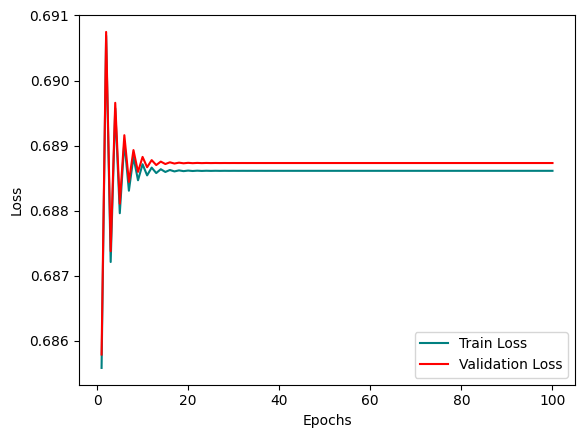

In [77]:
plt.tight_layout()
plt.plot(epochs, train_loss, color = 'teal', label = 'Train Loss')
plt.plot(epochs, test_loss, color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

### Observations
While the addition of a regularisation term caused instability in traiining for the first 15 epochs, the model was still able to converge from epoch 20.

<u>Increased variance, Reduced Bias</u>
- Variance: An increase in variance is observed as seen from the increase in standard deviation of variance performance metrics obtained from different randomised downsampled data sets.
- Bias: A decrease in accuracy and F1 score suggests lower bias to the train validation data set as the model fits less well to it.

<u>Test Performance</u>
- An improvement in test performance was observed with a corresponding increase in F1 score and accuracy. While this meant a deprovement in performance in the train validation data set, it was necessary for the model to generalise better on the unseen test data.

This model was chosen as the final, optimised model.

## 7. Summary of results

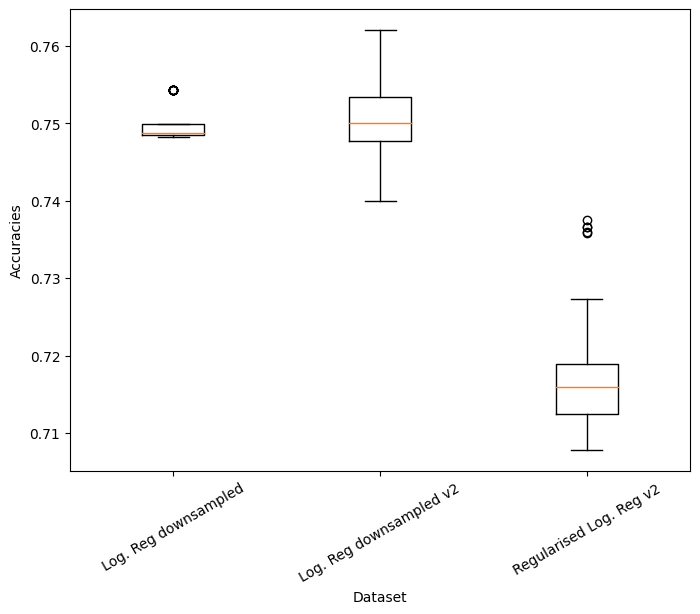

In [81]:
import matplotlib.pyplot as plt

# Assuming you have four arrays (data1, data2, data3, data4)
#acc_mse_unbalanced = np.load('results/mse_unbalanced/accuracies.npy')
#acc_logreg_unbalanced = np.load('results/logreg_unbalanced/accuracies.npy')
acc_logreg_balanced = np.load('results/logreg_balanced/accuracies.npy')
acc_logreg_balanced_final = np.load('results/logreg_final_ds/accuracies.npy')
acc_logreg_balanced_final_withreg = np.load('results/logreg_final_ds_withreg/accuracies.npy')

# Combine the data into a list of arrays
#combined_data = [acc_mse_unbalanced, acc_logreg_unbalanced, acc_logreg_balanced,
#                 acc_logreg_balanced_final, acc_logreg_balanced_final_withreg]
combined_data = [acc_logreg_balanced, acc_logreg_balanced_final, acc_logreg_balanced_final_withreg]

# Create a boxplot
acc_boxplot = plt.figure(figsize=(8, 6))
#plt.boxplot(combined_data, labels=['MSE raw', 'Log. Reg raw', 'Log. Reg downsampled',
#                                   'Log. Reg downsampled v2', 'Regularised Log. Reg v2'])
plt.boxplot(combined_data, labels=['Log. Reg downsampled', 'Log. Reg downsampled v2', 'Regularised Log. Reg v2'])

plt.xlabel('Dataset')
plt.xticks(rotation=30)
plt.ylabel('Accuracies')
plt.show()
acc_boxplot.savefig('accuracies.png', bbox_inches = 'tight')

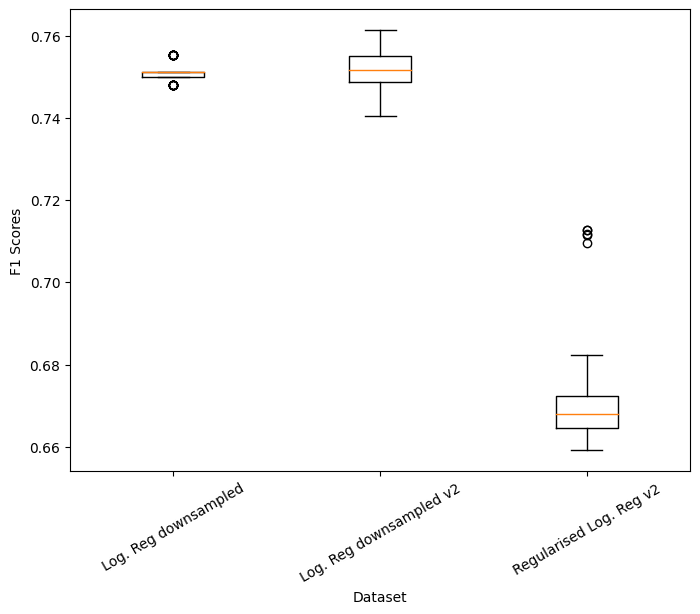

In [82]:
import matplotlib.pyplot as plt

# Assuming you have four arrays (data1, data2, data3, data4)
# acc_mse_unbalanced = np.load('results/mse_unbalanced/f1_scores.npy')
# acc_logreg_unbalanced = np.load('results/logreg_unbalanced/f1_scores.npy')
acc_logreg_balanced = np.load('results/logreg_balanced/f1_scores.npy')
acc_logreg_balanced_final = np.load('results/logreg_final_ds/f1_scores.npy')
acc_logreg_balanced_final_withreg = np.load('results/logreg_final_ds_withreg/f1_scores.npy')

# Combine the data into a list of arrays
# combined_data = [acc_mse_unbalanced, acc_logreg_unbalanced, acc_logreg_balanced,
#                 acc_logreg_balanced_final, acc_logreg_balanced_final_withreg]
combined_data = [acc_logreg_balanced, acc_logreg_balanced_final, acc_logreg_balanced_final_withreg]

# Create a boxplot
f1_boxplot = plt.figure(figsize=(8, 6))
# plt.boxplot(combined_data, labels=['MSE raw', 'Log. Reg raw', 'Log. Reg downsampled',
#                                   'Log. Reg downsampled v2', 'Regularised Log. Reg v2'])
plt.boxplot(combined_data, labels=['Log. Reg downsampled', 'Log. Reg downsampled v2', 'Regularised Log. Reg v2'])

plt.xlabel('Dataset')
plt.xticks(rotation=30)
plt.ylabel('F1 Scores')
plt.show()
f1_boxplot.savefig('f1_scores.png', bbox_inches = 'tight')

## 8. Generation of test submission

In [117]:
from data_loader import *
from provided_helpers import *

In [174]:
# Test submission
# Using logistic regression model

# Instantiate model
model = Model('logreg_withreg_gd')
x_train_np = load_x_data('datasets/updated_ds/x_train.npy')
x_test_np = load_x_data('datasets/updated_ds/x_test.npy')

print(x_train_np.shape) # (328135, 19)
print(x_test_np.shape) # (109379, 19)

y_train = load_y_data('datasets/updated_ds/y_train.npy', True)
print(y_train.shape) # (328135,)

# Downsample dataset
x_train_downsampled, y_train_downsampled = downsample_ds(x_train_np, y_train)
print(x_train_downsampled.shape)
print(y_train_downsampled.shape)

# Train the model
initial_w = np.zeros((x_train_downsampled.shape[1],), dtype = np.float64)
max_iters = 100
gamma = 0.1
lambda_ = 8.25
weights, _ = model.train(y_train_downsampled, x_train_downsampled, lambda_, initial_w, max_iters, gamma)

# Get the predictions for x_test
y_test_pred = model.predict(x_test_np)

# Format to {-1, 1} from {0, 1}.
y_test_pred[y_test_pred == 0] = -1

# Get test observations ids
ids = np.load('datasets/updated_ds/test_ids.npy')

# Generate csv_submission
create_csv_submission(ids, y_test_pred, 'submission.csv')

(328135, 19)
(109379, 19)
(328135,)
(57950, 19)
(57950,)


In [176]:
k_fold = 5
k_indices = build_k_indices(y_train_downsampled, k_fold)
train_x, train_y, test_x, test_y = get_kfold_train_test(y_train_downsampled,
                                            x_train_downsampled, k_indices, 0)

# Train the model
model = Model('logreg_withreg_gd')

initial_w = np.zeros((x_train_downsampled.shape[1],), dtype = np.float64)
max_iters = 100
gamma = 0.1
lambda_ = 8.25
weights, _ = model.train(y_train_downsampled, x_train_downsampled, lambda_, initial_w, max_iters, gamma)

# Get the predictions for x_test
test_y_pred = model.predict(test_x)

print(model.calc_acc(test_y, test_y_pred))
print(model.calc_metrics(test_y, test_y_pred))

0.7120793787748059
(0.5634045485871813, 0.8028480235698502, 0.6621443758226183)
